In [37]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [84]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

In [38]:
WORKING_DIRECTORY = './drive/MyDrive/Colab\ Notebooks/diploma/'

In [3]:
 # Создаём SparkSession
spark = SparkSession.builder \
    .appName("PetCo") \
    .getOrCreate()

In [44]:
# Read dataset with beh logs
data_logs = spark.read.parquet(WORKING_DIRECTORY+'data/needed_beh_logs')

In [45]:
data_logs.show()

+----------------+--------------------+-----+--------------------+--------------------+--------------------+-----------------+-------------+--------------------+--------------------+-----------+--------------------+------------+--------------------+--------------------+--------------------+-------+
|customer_user_id|              ac_key|ac_id|             user_id|          session_id|           timestamp|         raw_term|  filter_name|        filter_value|              action|customer_id|           item_name|variation_id|      variation_name|               items|            items_v2|revenue|
+----------------+--------------------+-----+--------------------+--------------------+--------------------+-----------------+-------------+--------------------+--------------------+-----------+--------------------+------------+--------------------+--------------------+--------------------+-------+
|       435675978|key_afiSr5Y4gCaaSW5X| 2560|e5fbf045-94fa-498...|e5fbf045-94fa-498...|2024-11-29 10

In [48]:
data_logs.printSchema()  # Структура данных

root
 |-- customer_user_id: string (nullable = true)
 |-- ac_key: string (nullable = true)
 |-- ac_id: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- raw_term: string (nullable = true)
 |-- filter_name: string (nullable = true)
 |-- filter_value: string (nullable = true)
 |-- action: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- item_name: string (nullable = true)
 |-- variation_id: long (nullable = true)
 |-- variation_name: string (nullable = true)
 |-- items: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- customer_id: string (nullable = true)
 |    |    |-- item_id: long (nullable = true)
 |    |    |-- item_name: string (nullable = true)
 |    |    |-- price: double (nullable = true)
 |-- items_v2: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- customer_id: string (nullabl

In [111]:
print(f'Число строк: {data_logs.count()}')

Число строк: 4265321


In [60]:
n_users = data_logs.select('user_id').distinct().count()
print(f'Число пользователей: {n_users}')

Число пользователей: 76399


In [81]:
# Предположим, что df — это ваш DataFrame
#data_logs = data_logs.withColumn("timestamp", F.col("timestamp").cast("timestamp"))
data_logs = data_logs.withColumn("formatted_timestamp", F.date_format("timestamp", "yyyy-MM-dd HH:mm:ss"))
# Нахождение минимальной и максимальной даты
min_date = data_logs.agg(F.min("formatted_timestamp").alias("min_date")).collect()[0]["min_date"]
max_date = data_logs.agg(F.max("formatted_timestamp").alias("max_date")).collect()[0]["max_date"]

print(f"Разброс дат: {min_date, max_date}")

Разброс дат: ('2024-06-06 00:00:00', '2024-12-01 00:00:00')


In [109]:
# Группируем по 'user_id' и считаем количество строк для каждого 'user_id'
user_counts = data_logs.groupBy("user_id").count()
average_count = user_counts.agg(F.avg("count")).collect()[0][0]
median_count = user_counts.approxQuantile('count', [0.5], 0.01)[0]

print(f"Среднее число итеракций: {round(average_count, 1)}")
print(f'Медианное число итеракций: {median_count}')

Среднее число итеракций: 55.8
Медианное число итеракций: 24.0


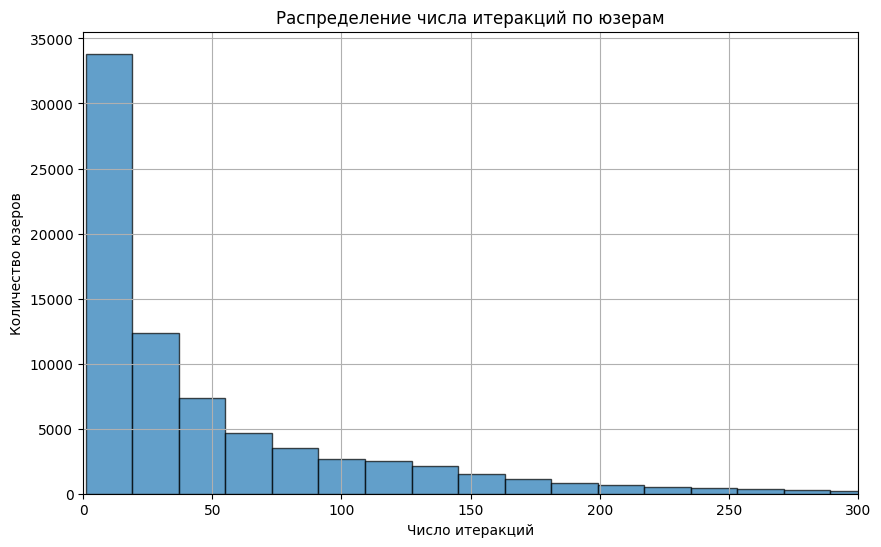

In [105]:
# Преобразуем в pandas DataFrame
user_counts_pd = user_counts.toPandas()

# Строим гистограмму распределения
plt.figure(figsize=(10, 6))
plt.hist(user_counts_pd['count'], bins=400, edgecolor='black', alpha=0.7)
plt.title("Распределение числа итеракций по юзерам")
plt.xlabel("Число итеракций")
plt.ylabel("Количество юзеров")
plt.grid(True)
plt.xlim(left=0, right=300)
plt.show()

In [112]:
data_purchases = data_logs.filter(data_logs.action == 'purchase')

In [114]:
data_purchases.show()

+----------------+--------------------+-----+--------------------+--------------------+-------------------+--------+-----------+------------+--------+-----------+---------+------------+--------------+--------------------+--------------------+-------+-------------------+
|customer_user_id|              ac_key|ac_id|             user_id|          session_id|          timestamp|raw_term|filter_name|filter_value|  action|customer_id|item_name|variation_id|variation_name|               items|            items_v2|revenue|formatted_timestamp|
+----------------+--------------------+-----+--------------------+--------------------+-------------------+--------+-----------+------------+--------+-----------+---------+------------+--------------+--------------------+--------------------+-------+-------------------+
|       635619080|key_afiSr5Y4gCaaSW5X| 1947|6521ca44-0aed-409...|6521ca44-0aed-409...|2024-11-29 00:00:00|    null|       null|        null|purchase|       null|     null|        null|  

In [116]:
n_users_purchased = data_purchases.select('user_id').distinct().count()
print(f'Число пользователей, которые сделали покупки: {n_users_purchased}')

Число пользователей, которые сделали покупки: 42295


In [129]:
# Группируем по 'user_id' и считаем количество строк для каждого 'user_id'
user_counts_purchased = data_purchases.groupBy("user_id").count()
average_count_purchases = user_counts_purchased.agg(F.avg("count")).collect()[0][0]
median_count_purchases = user_counts_purchased.approxQuantile('count', [0.5], 0.01)[0]

print(f"Среднее число покупок: {round(average_count_purchases, 1)}")
print(f'Медианное число покупок: {median_count_purchases}')

Среднее число покупок: 1.8
Медианное число покупок: 1.0


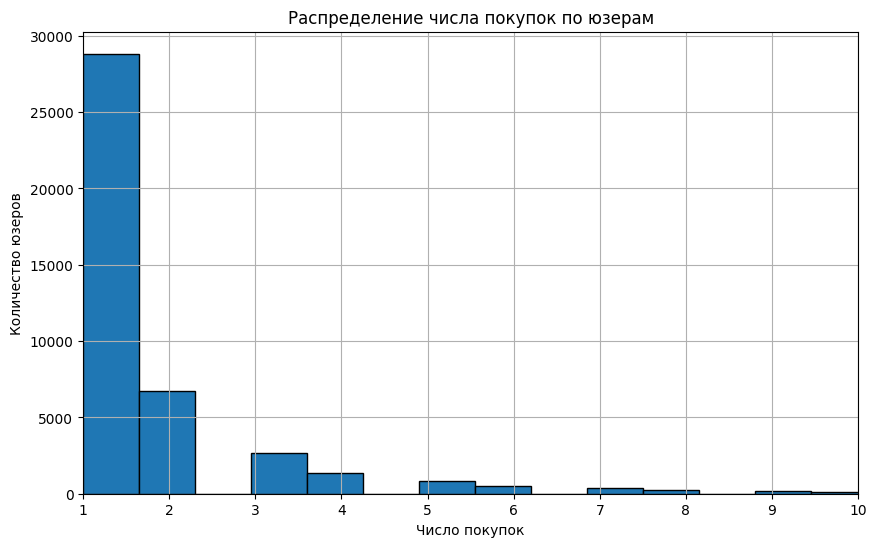

In [137]:
# Преобразуем в pandas DataFrame
user_counts_pd_purchases = user_counts_purchased.toPandas()

# Строим гистограмму распределения
plt.figure(figsize=(10, 6))
plt.hist(user_counts_pd_purchases['count'], bins=100, edgecolor='black')
plt.title("Распределение числа покупок по юзерам")
plt.xlabel("Число покупок")
plt.ylabel("Количество юзеров")
plt.grid(True)
plt.xlim(left=1, right=10)
plt.show()